---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Topic**: Working with Large Language Models (LLMs) via API

🚫 **Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Overview

Today we'll learn how to work with Large Language Models (LLMs) through their APIs. By the end of this lecture, you'll be able to:

1. **Use Provider SDKs** - Call OpenAI, Anthropic, and Google directly
2. **Use LiteLLM** - One unified interface for all providers
3. **Handle Failures** - Implement retries with exponential backoff
4. **Understand Pydantic** - Python's data validation library
5. **Get Structured Outputs** - Guaranteed JSON responses from LLMs
6. **Use Async** - Make concurrent API calls for speed
7. **Use Instructor** - Alternative approach to structured outputs
8. **Generate Images** - Create images with Google Imagen

Let's get started!

---

# 1. Setup: API Keys and Environment

Before we can call any LLM, we need API keys. These are like passwords that identify you to the service.

## 1.1 Getting API Keys

| Provider | Where to Get Key | Cost |
|----------|-----------------|------|
| **OpenAI** | [platform.openai.com](https://platform.openai.com) | Pay-as-you-go |
| **Anthropic** | [console.anthropic.com](https://console.anthropic.com) | Pay-as-you-go |
| **Google** | [aistudio.google.com](https://aistudio.google.com) | Free tier available |

## 1.2 Storing Keys Securely

Never put API keys in your code! Instead, use a `.env` file (in your project root)
```python
OPENAI_API_KEY=sk-your-key-here
ANTHROPIC_API_KEY=sk-ant-your-key-here
GOOGLE_API_KEY=your-google-key-here
```

Make sure `.env` is in your `.gitignore` so you don't accidentally commit your keys!

In [2]:
# Load environment variables from .env file
import os
import warnings
from dotenv import load_dotenv

# Suppress noisy warnings
warnings.filterwarnings("ignore")

# Load the .env file
load_dotenv()

# Verify keys are loaded (don't print actual keys!)
print("OpenAI key loaded:", "OPENAI_API_KEY" in os.environ)
print("Anthropic key loaded:", "ANTHROPIC_API_KEY" in os.environ)
print("Google key loaded:", "GOOGLE_API_KEY" in os.environ)

OpenAI key loaded: True
Anthropic key loaded: False
Google key loaded: True


---

# 2. Provider SDKs: The Native Way

Each LLM provider has their own Python SDK. Let's see how each one works.

## 2.1 OpenAI SDK

OpenAI's SDK is the most widely used. It powers the GPT-4.1 series and more.

In [ ]:
# Using Google Gemini instead of OpenAI
from google import genai
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Create a Gemini client
google_client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

# Make a chat completion request
try:
    response = google_client.models.generate_content(
        model="gemini-2.0-flash-exp",  # Using Gemini Flash model
        contents="What is Python in exactly one sentence?"
    )
    
    # Extract the response
    print("Gemini Response:")
    print(response.text)
    
except Exception as e:
    print(f"❌ Error: {type(e).__name__}")
    print(f"Error details: {e}")

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

### OpenAI Response Structure

The response is a `ChatCompletion` object. Key parts:

```python
response.choices[0].message.content  # The actual text response
response.choices[0].finish_reason    # Why generation stopped ("stop", "length", etc.)
response.usage.total_tokens          # Tokens used (for billing)
```

## 2.2 Anthropic SDK

Anthropic makes Claude models. Their API is slightly different.

In [ ]:
from anthropic import Anthropic

# Create a client
anthropic_client = Anthropic()

# Make a message request (note: different method name!)
response = anthropic_client.messages.create(
    model="claude-3-5-haiku-20241022",
    max_tokens=1024,  # Required for Anthropic!
    messages=[
        {"role": "user", "content": "What is Python in exactly one sentence?"}
    ]
)

# Extract the response (different structure!)
print("Anthropic Response:")
print(response.content[0].text)

### Anthropic Response Structure

Different from OpenAI:

```python
response.content[0].text    # The actual text (not .message.content!)
response.stop_reason        # Why it stopped
response.usage.input_tokens # Tokens used
```

## 2.3 Google Gemini SDK

Google's SDK is different again. They use the `google-genai` package.

In [3]:
from google import genai

# Create a client
google_client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

# Generate content (yet another API style!)
response = google_client.models.generate_content(
    model="gemini-2.5-flash",
    contents="What is Python in exactly one sentence?"
)

# Extract the response
print("Google Response:")
print(response.text)

Google Response:
Python is a high-level, general-purpose programming language known for its clear, readable syntax and used for a wide variety of applications including web development, data science, and artificial intelligence.


## 2.4 The Problem: Three APIs, Three Formats

Notice how each provider has:
- Different client initialization
- Different method names (`chat.completions.create` vs `messages.create` vs `generate_content`)
- Different response structures
- Different parameter names

This makes it hard to:
- Switch providers
- Compare models
- Write reusable code

**Solution: LiteLLM** - One API to rule them all!

---

# 3. LiteLLM: Unified Interface

LiteLLM provides a single, consistent API that works with 100+ LLM providers.

| Benefit | Description |
|---------|-------------|
| **One API** | Same code for any provider |
| **Easy Switching** | Change one line to switch models |
| **Fallbacks** | Automatically try another provider if one fails |
| **Cost Tracking** | Built-in usage monitoring |

In [5]:
import litellm

# Same function works with ANY provider!
def ask_llm(prompt: str, model: str = "gpt-5-mini") -> str:
    """Ask any LLM a question using LiteLLM."""
    response = litellm.completion(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

In [ ]:
# OpenAI
print("GPT-5-mini:", ask_llm("Say 'hello' in French", model="gpt-5-mini"))

In [ ]:
# Anthropic (same code, different model!)
print("Claude Haiku:", ask_llm("Say 'hello' in French", model="claude-3-5-haiku-20241022"))

In [6]:
# Google (same code, just add "gemini/" prefix)
print("Gemini Flash:", ask_llm("Say 'hello' in French", model="gemini/gemini-2.5-flash"))

Gemini Flash: Bonjour!


### Model Name Reference

| Provider | Model Name | Notes |
|----------|-----------|-------|
| **OpenAI** | `gpt-5.2` | Most capable (latest) |
| | `gpt-5.2-pro` | More compute, better answers |
| | `gpt-5.1` | Great for coding/agentic tasks |
| | `gpt-5-mini` | Fast and cheap |
| **Anthropic** | `claude-opus-4-5-20251101` | Most capable |
| | `claude-sonnet-4-5-20250929` | Best balance |
| | `claude-3-5-haiku-20241022` | Fast and cheap |
| **Google** | `gemini/gemini-2.5-pro` | Most capable |
| | `gemini/gemini-2.5-flash` | Fast and cheap |

**Note**: We use `gpt-5-mini` in examples because it's cost-effective for learning.

### System Messages and Conversation History

LLMs understand different "roles" in a conversation:

In [8]:
response = litellm.completion(
    model="gemini/gemini-2.5-flash",
    messages=[
        # System message: sets the behavior/personality
        {"role": "system", "content": "You are a helpful pirate. Always respond like a pirate."},
        # User message: the actual question
        {"role": "user", "content": "What's the weather like?"}
    ]
)

print(response.choices[0].message.content)

Ahoy there, matey! The winds be blowin' fair, a brisk breeze fillin' the sails, and the sun's high in the sky, bright enough to spot a treasure chest a league away! A grand day for sailin' the high seas, it is! No sign o' squalls or stormy waters yet, just calm seas and clear skies, perfect for a grand adventure!


---

# 4. Making API Calls Robust: Retries

API calls can fail for many reasons:
- **Rate limiting** (HTTP 429) - too many requests
- **Server errors** (HTTP 500) - provider issues
- **Timeouts** - network issues

**Solution:** Retry with exponential backoff

## 4.1 Manual Retry Pattern

Here's how to implement retries from scratch:

In [9]:
import time
import random

def call_with_retries(prompt: str, max_retries: int = 5, base_delay: float = 1.0) -> str:
    """
    Call LLM with exponential backoff retry.
    
    Wait times: 1s -> 2s -> 4s -> 8s -> 16s (plus random jitter)
    """
    for attempt in range(1, max_retries + 1):
        try:
            response = litellm.completion(
                model="gemini/gemini-2.5-flash",
                messages=[{"role": "user", "content": prompt}]
            )
            return response.choices[0].message.content
        except Exception as e:
            if attempt == max_retries:
                raise  # Give up after max retries
            
            # Exponential backoff with jitter
            delay = base_delay * (2 ** (attempt - 1)) + random.random()
            print(f"Attempt {attempt} failed: {e}. Retrying in {delay:.1f}s...")
            time.sleep(delay)

# Test it
result = call_with_retries("Say 'hello'")
print(result)

Hello!


## 4.2 Using Tenacity Library

Writing retry logic is tedious. The `tenacity` library makes it elegant:

In [ ]:
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

@retry(
    stop=stop_after_attempt(5),           # Max 5 attempts
    wait=wait_exponential(multiplier=1, min=1, max=60),  # Exponential backoff
    reraise=True                          # Re-raise the exception if all retries fail
)
def robust_llm_call(prompt: str, model: str = "gemini/gemini-2.5-flash") -> str:
    """Call LLM with automatic retries."""
    response = litellm.completion(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

# The decorator handles all retry logic!
result = robust_llm_call("What is 2 + 2?")
print(result)

2 + 2 = 4


## 4.3 Built-in Client Retries

The OpenAI client has built-in retry support:

In [ ]:
from openai import OpenAI

# Create client with automatic retries
client = OpenAI(
    max_retries=5,  # Automatically retry up to 5 times
    timeout=30.0    # Timeout after 30 seconds
)

# Now all calls through this client will automatically retry!
response = client.chat.completions.create(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": "Hello!"}]
)
print(response.choices[0].message.content)

In [15]:
from google import genai

# Uses GOOGLE_API_KEY from environment
client = genai.Client()

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents="Hello!whats todays date?"
)

print(response.text)


Today is **June 11, 2024**.


---

# 5. What is Pydantic?

**Pydantic** is Python's most popular data validation library. It lets you:

- Define data structures with types
- Automatically validate data
- Get helpful error messages
- Serialize to/from JSON

It's used everywhere in modern Python: FastAPI, LangChain, Django Ninja, and more.

## 5.1 Basic Pydantic Model

In [16]:
from pydantic import BaseModel, Field

# Define a data structure
class Person(BaseModel):
    name: str
    age: int = Field(ge=0, le=150)  # Must be 0-150
    email: str | None = None        # Optional field

# Create an instance - Pydantic validates automatically!
person = Person(name="Alice", age=30, email="alice@example.com")
print(person)
print(f"Name: {person.name}, Age: {person.age}")

name='Alice' age=30 email='alice@example.com'
Name: Alice, Age: 30


In [17]:
# Pydantic catches invalid data
try:
    invalid_person = Person(name="Bob", age=200)  # Age > 150!
except Exception as e:
    print(f"Validation error: {e}")

Validation error: 1 validation error for Person
age
  Input should be less than or equal to 150 [type=less_than_equal, input_value=200, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/less_than_equal


In [18]:
# Pydantic auto-converts types when possible
person = Person(name="Charlie", age="25")  # String "25" -> int 25
print(f"Age is {person.age}, type: {type(person.age)}")

Age is 25, type: <class 'int'>


## 5.2 Serialization (to/from JSON)

In [19]:
# Convert to JSON
person = Person(name="Diana", age=28)
json_str = person.model_dump_json(indent=2)
print("As JSON:")
print(json_str)

As JSON:
{
  "name": "Diana",
  "age": 28,
  "email": null
}


In [20]:
# Parse from JSON
json_data = '{"name": "Eve", "age": 35, "email": "eve@example.com"}'
person = Person.model_validate_json(json_data)
print(f"Parsed: {person.name}, {person.age}")

Parsed: Eve, 35


## 5.3 Why Pydantic Matters for LLMs

LLMs return free-form text. Pydantic lets us:

1. **Define what we want** - Create a schema/model
2. **Get structured data** - LLM returns JSON matching our schema
3. **Validate automatically** - Pydantic checks the data is correct
4. **Use easily** - Access fields with dot notation

---

# 6. Structured Outputs with Pydantic

The **problem**: LLMs return free-form text that's hard to parse.

Ask "extract info from this review" and you might get:
- "The sentiment is positive and the rating is 4.5"
- "Rating: 4.5/5, Sentiment: positive"
- "Positive review! 4.5 stars."

**Solution**: Use `response_format` to get guaranteed JSON structure.

In [21]:
from pydantic import BaseModel, Field
from typing import Literal

# Define the structure we want
class MovieReview(BaseModel):
    """Structured data extracted from a movie review."""
    sentiment: Literal["positive", "negative", "neutral"] = Field(
        description="The overall sentiment of the review"
    )
    rating: float = Field(
        description="Numeric rating from 1.0 to 5.0",
        ge=1.0,
        le=5.0
    )
    key_points: list[str] = Field(
        description="Main points mentioned in the review (1-5 items)",
        min_length=1,
        max_length=5
    )
    reviewer_name: str | None = Field(
        default=None,
        description="Name of the reviewer if mentioned"
    )

In [22]:
# A sample review to analyze
review_text = """
This movie was absolutely fantastic! The cinematography was stunning, 
and the acting performances were top-notch. I'd give it 4.5 stars. 
The plot kept me engaged from start to finish. Highly recommend!
- Sarah Johnson
"""

# Use LiteLLM with response_format
response = litellm.completion(
    model="gpt-5-mini",
    messages=[
        {
            "role": "system",
            "content": "Extract structured information from movie reviews."
        },
        {
            "role": "user",
            "content": f"Extract information from this review:\n\n{review_text}"
        }
    ],
    response_format=MovieReview  # Tell the LLM to return this structure!
)

# Parse the JSON response into our Pydantic model
review_data = MovieReview.model_validate_json(response.choices[0].message.content)

# Now we have clean, typed data!
print(f"Sentiment: {review_data.sentiment}")
print(f"Rating: {review_data.rating}")
print(f"Key Points: {review_data.key_points}")
print(f"Reviewer: {review_data.reviewer_name}")


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.



RateLimitError: litellm.RateLimitError: RateLimitError: OpenAIException - You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.

## 6.1 Nested Models

You can create complex structures with nested Pydantic models:

In [ ]:
class Actor(BaseModel):
    """Information about an actor."""
    name: str
    role: str

class MovieInfo(BaseModel):
    """Comprehensive movie information."""
    title: str
    year: int = Field(ge=1900, le=2030)
    genre: list[str]
    director: str
    actors: list[Actor]  # Nested model!
    plot_summary: str = Field(max_length=500)

# Use it
response = litellm.completion(
    model="gpt-5-mini",
    messages=[
        {"role": "user", "content": "Give me information about the movie Inception"}
    ],
    response_format=MovieInfo
)

movie = MovieInfo.model_validate_json(response.choices[0].message.content)
print(f"Title: {movie.title} ({movie.year})")
print(f"Director: {movie.director}")
print(f"Genres: {', '.join(movie.genre)}")
print(f"\nActors:")
for actor in movie.actors:
    print(f"  - {actor.name} as {actor.role}")

---

# 7. Async Programming

**Problem**: If you need to make 100 LLM calls, doing them one-by-one is slow.

**Solution**: Make them concurrently with async programming.

## 7.1 What is Async?

Think of it like ordering at a restaurant:

- **Synchronous**: Order one dish, wait for it, eat it, then order the next
- **Asynchronous**: Order all dishes at once, they arrive as they're ready

Key Python concepts:

| Keyword | Meaning |
|---------|---------|
| `async def` | Defines an async function |
| `await` | Pause here until the result is ready |
| `asyncio.gather()` | Run multiple async tasks concurrently |

## 7.2 Sequential vs Concurrent

In [ ]:
import time

# A list of prompts to process
prompts = [
    "What is the capital of France?",
    "What is the capital of Germany?",
    "What is the capital of Italy?",
    "What is the capital of Spain?",
    "What is the capital of Portugal?",
    "What is the capital of Greece?",
    "What is the capital of Turkey?",
    "What is the capital of Bulgaria?",
    "What is the capital of Romania?",
    "What is the capital of Hungary?",
    "What is the capital of Poland?",
    "What is the capital of Czech Republic?",
]

# Sequential: one at a time
start = time.time()
sequential_results = []
for prompt in prompts:
    response = litellm.completion(
        model="gpt-5-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    sequential_results.append(response.choices[0].message.content)
sequential_time = time.time() - start

print(f"Sequential: {sequential_time:.2f} seconds")
for prompt, result in zip(prompts, sequential_results):
    print(f"  {prompt} -> {result[:50]}...")

In [ ]:
import asyncio

# Async function to call LLM
async def async_ask(prompt: str) -> str:
    """Make an async LLM call."""
    response = await litellm.acompletion(  # Note: acompletion, not completion!
        model="gpt-5-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

# Async function to process all prompts concurrently
async def process_all(prompts: list[str]) -> list[str]:
    """Process all prompts concurrently."""
    tasks = [async_ask(prompt) for prompt in prompts]
    return await asyncio.gather(*tasks)

# Run concurrently
start = time.time()
concurrent_results = await process_all(prompts)
concurrent_time = time.time() - start

print(f"Concurrent: {concurrent_time:.2f} seconds")
print(f"Speedup: {sequential_time / concurrent_time:.1f}x faster!")

## 7.3 When to Use Async

Use async when:
- Processing many items (batch analysis)
- Making independent API calls
- Building web applications (FastAPI uses async)

Don't bother for:
- Single API calls
- Sequential workflows where each step depends on the previous

---

# 8. Instructor Library

**Instructor** is another approach to structured outputs. It:

- Patches existing clients (OpenAI, Anthropic, etc.)
- Returns Pydantic objects directly (not JSON strings)
- Has built-in retry and validation
- Works with multiple providers

In [ ]:
import instructor
from openai import OpenAI
from pydantic import BaseModel

# Patch the OpenAI client with Instructor
client = instructor.from_openai(OpenAI())

# Define what we want
class UserInfo(BaseModel):
    name: str
    age: int
    occupation: str

# Use it - returns a Pydantic object directly!
user = client.chat.completions.create(
    model="gpt-5-mini",
    messages=[
        {"role": "user", "content": "Generate a random person's info"}
    ],
    response_model=UserInfo  # Instructor uses response_model, not response_format
)

# user is already a UserInfo object!
print(f"Name: {user.name}")
print(f"Age: {user.age}")
print(f"Occupation: {user.occupation}")

## 8.1 Instructor with Anthropic

In [ ]:
from anthropic import Anthropic

# Patch Anthropic client
anthropic_instructor = instructor.from_anthropic(Anthropic())

# Same interface!
user = anthropic_instructor.messages.create(
    model="claude-3-5-haiku-20241022",
    max_tokens=1024,
    messages=[
        {"role": "user", "content": "Generate a random person's info"}
    ],
    response_model=UserInfo
)

print(f"From Claude: {user.name}, {user.age}, {user.occupation}")

## 8.2 Instructor vs LiteLLM: When to Use Each

| Feature | LiteLLM | Instructor |
|---------|---------|------------|
| **Multi-provider** | Yes (100+ providers) | Yes (OpenAI, Anthropic, etc.) |
| **Structured output** | Returns JSON string | Returns Pydantic object |
| **Retry built-in** | No (use tenacity) | Yes |
| **Validation retry** | No | Yes (retries if validation fails) |
| **Learning curve** | Lower | Slightly higher |

**Use LiteLLM when**: You want unified access to many providers

**Use Instructor when**: You want the cleanest structured output experience

---

# 9. Image Generation with Gemini (Nano Banana)

Gemini models can generate images natively - no separate Imagen model needed! This feature is called "Nano Banana" internally at Google.

In [23]:
from google import genai
from google.genai import types
from pathlib import Path

# Create client
google_client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

# Generate an image using Nano Banana (Gemini's native image generation)
response = google_client.models.generate_content(
    model="gemini-2.5-flash-image",  # Nano Banana model
    contents=["A cute robot learning to code, digital art style"],
)

# Find and save the image from the response
output_path = Path("temp/robot_coding.png")
output_path.parent.mkdir(exist_ok=True)

for part in response.parts:
    if part.inline_data is not None:
        image = part.as_image()
        image.save(output_path)
        print(f"Image saved to {output_path}")
        break

Image saved to temp/robot_coding.png


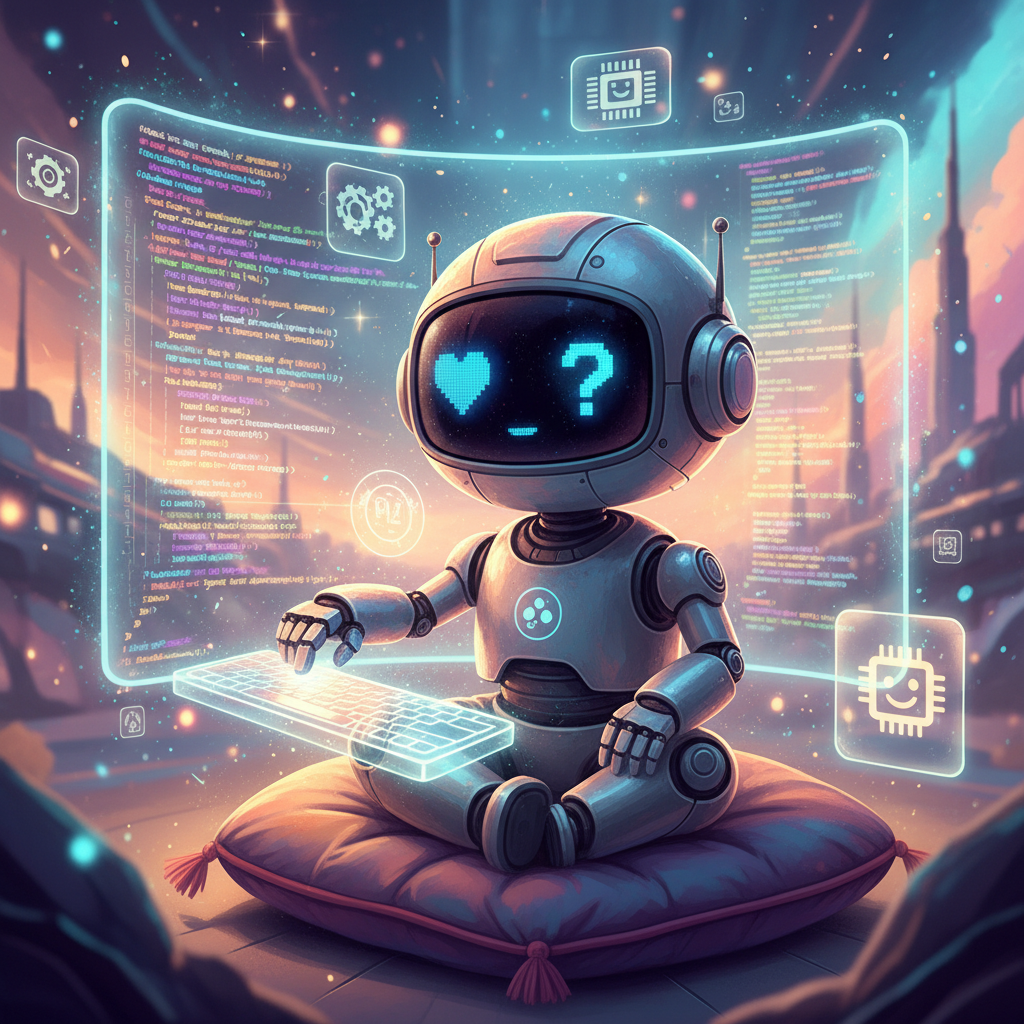

In [24]:
# Display the image in Jupyter
from IPython.display import Image, display

if output_path.exists():
    display(Image(filename=str(output_path), width=400))
else:
    print("Run the previous cell first to generate the image!")

## 9.2 Nano Banana Pro (Gemini 3)

For complex prompts that need reasoning, use **Nano Banana Pro**. It "thinks" before generating, making it great for:
- Infographics with text
- Complex compositions
- Multi-element scenes

In [25]:
# Nano Banana Pro - uses "thinking" for complex prompts
from google.genai import types

response = google_client.models.generate_content(
    model="gemini-3-pro-image-preview",  # Nano Banana Pro
    contents=["Create a detailed infographic showing how neural networks learn, "
              "with clear labels, arrows showing data flow, and a modern tech aesthetic"],
    config=types.GenerateContentConfig(
        response_modalities=['TEXT', 'IMAGE'],
        thinking_config=types.ThinkingConfig(
            include_thoughts=True  # Enable "thinking" mode
        )
    )
)

# Save the pro image
pro_output_path = Path("temp/neural_network_infographic.png")

for part in response.parts:
    if part.inline_data is not None:
        image = part.as_image()
        image.save(pro_output_path)
        print(f"Pro image saved to {pro_output_path}")
        break
    elif part.text is not None:
        print(f"Model's thoughts: {part.text[:200]}...")  # Show reasoning

Model's thoughts: **Clarifying Neural Network Learning**

I'm now focusing on the visual layout. The goal is to depict the neural network learning cycle clearly. I'm structuring the infographic from left to right, and ...
Pro image saved to temp/neural_network_infographic.png


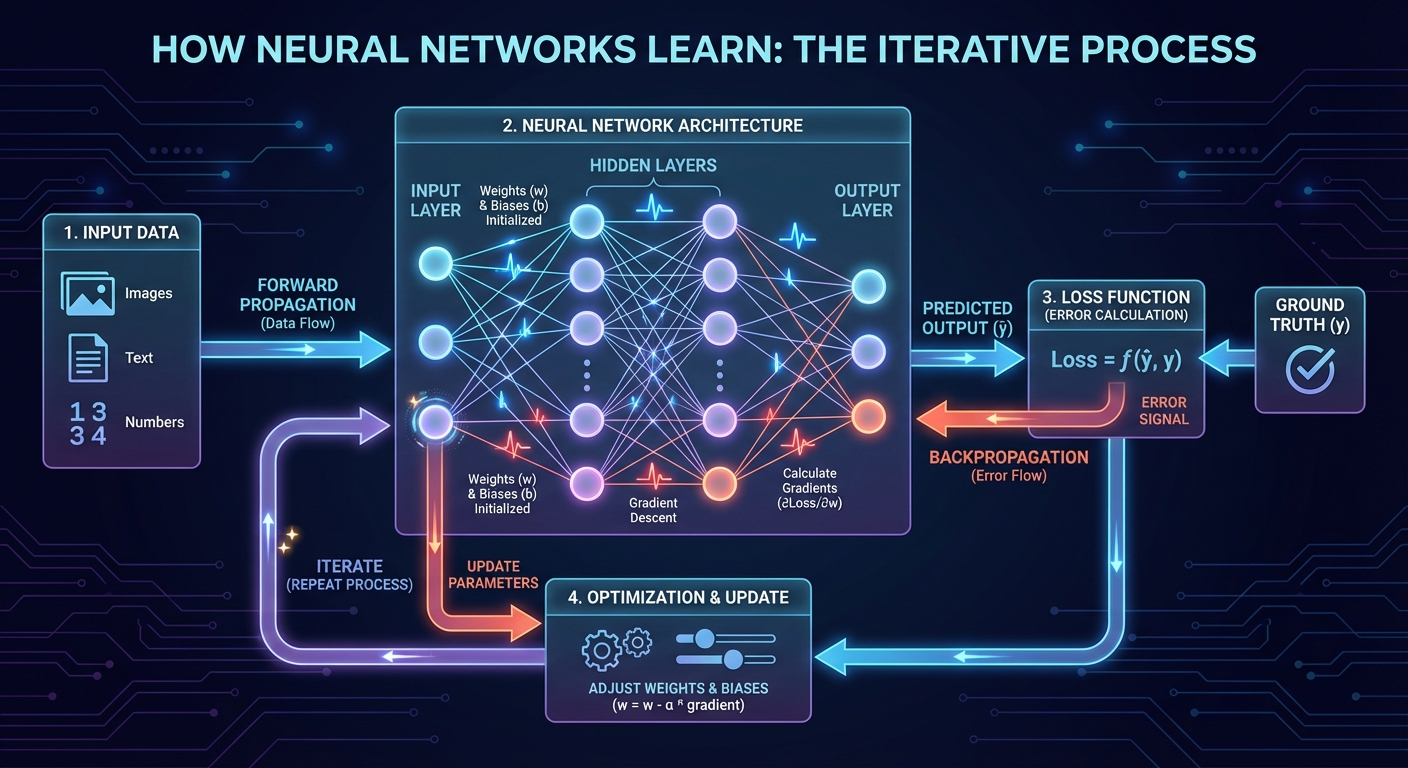

In [26]:
# Display the Pro image
if pro_output_path.exists():
    display(Image(filename=str(pro_output_path), width=500))
else:
    print("Run the previous cell first!")

## 9.3 Tips for Image Generation

**Nano Banana models**:
| Model | ID | Best For |
|-------|-----|----------|
| **Nano Banana** | `gemini-2.5-flash-image` | Fast, high-volume tasks |
| **Nano Banana Pro** | `gemini-3-pro-image-preview` | Pro quality, complex prompts |

**Good prompts**:
- Be specific: "A golden retriever puppy playing in autumn leaves, photograph"
- Include style: "digital art", "oil painting", "photograph", "3D render"
- Describe lighting: "sunset lighting", "studio lighting"

**With aspect ratio**:
```python
response = client.models.generate_content(
    model="gemini-2.5-flash-image",
    contents=["your prompt"],
    config=types.GenerateContentConfig(
        response_modalities=['TEXT', 'IMAGE'],
        image_config=types.ImageConfig(aspect_ratio="16:9")
    )
)
```

**Edit existing images**:
```python
from PIL import Image
img = Image.open("photo.png")
response = client.models.generate_content(
    model="gemini-2.5-flash-image",
    contents=["Add a wizard hat", img],  # Pass image + edit instruction
)
```

**Note**: All images include an invisible SynthID watermark.

---

# 10. Summary

Today we covered a lot! Here's a quick reference:

| Topic | Key Takeaway |
|-------|-------------|
| **Provider SDKs** | Each provider has different APIs (OpenAI, Anthropic, Google) |
| **LiteLLM** | Unified interface for all providers - use this! |
| **Retries** | Use `tenacity` or built-in client retries for robustness |
| **Pydantic** | Data validation library for defining schemas |
| **Structured Outputs** | Use `response_format` for guaranteed JSON |
| **Async** | Use `acompletion` + `asyncio.gather` for concurrent calls |
| **Instructor** | Alternative for structured outputs with validation retries |
| **Nano Banana** | Gemini's native image generation (`gemini-2.5-flash-image`) |

## Quick Code Reference

```python
# Basic LLM call with LiteLLM
response = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": "Hello!"}]
)

# Structured output
response = litellm.completion(
    model="gpt-5-mini",
    messages=[...],
    response_format=MyPydanticModel
)
data = MyPydanticModel.model_validate_json(response.choices[0].message.content)

# Async call
response = await litellm.acompletion(model="gpt-5-mini", messages=[...])

# Image generation (Nano Banana)
response = client.models.generate_content(
    model="gemini-2.5-flash-image",
    contents=["your prompt"]
)
```

## Resources

- [LiteLLM Documentation](https://docs.litellm.ai)
- [Pydantic Documentation](https://docs.pydantic.dev)
- [Instructor Documentation](https://python.useinstructor.com)
- [OpenAI API Reference](https://platform.openai.com/docs)
- [Anthropic API Reference](https://docs.anthropic.com)
- [Google Gemini API](https://ai.google.dev/gemini-api/docs)
- [Tenacity Documentation](https://tenacity.readthedocs.io)